In [1]:
from minigraphs.mcmc import SimulatedAnnealing
from minigraphs.mcmc.chains import SubgraphUniform
from minigraphs.metrics import graph_spectrum
from minigraphs.reduction import CoarseNET
from minigraphs.data import load_graph

# Load Hamsterster graph
graph_hamsterster = load_graph('hamsterster')
rad_hamsterster = graph_spectrum(graph_hamsterster)[0]

print(f"Hamsterster spectral radius: {rad_hamsterster:.2f}")

Hamsterster spectral radius: 50.02


In [2]:
import numpy as np 
from tqdm import tqdm 
from minigraphs.metrics import algebraic_connectivity
from minigraphs.mcmc.chains import SubgraphBoundary

n_sizes = 2
sizes = [200]
radii = []

n_steps = 10000
rate = n_steps / 100
schedule = lambda step: np.exp(step / rate)

for size in tqdm(sizes):
    # Reduce with CoarseNET
    alpha = 1 - size / 2000
    coarsener = CoarseNET(alpha, graph_hamsterster)
    coarsener.coarsen()

    rad_coarsen = graph_spectrum(coarsener.G_coarse_)[0]

    # Reduce with MCMC
    annealer = SimulatedAnnealing(
        SubgraphBoundary(graph_hamsterster,size, 10),
        energy=lambda graph: -graph_spectrum(graph)[0], #- np.log2(algebraic_connectivity(graph)/size + 1/256),
        schedule=schedule,
        max_steps=n_steps,
    )

    annealer.run()
    rad_annealing = annealer.best_graph_[1]

    radii.append(
        {'coarsen': rad_coarsen, 'mh': rad_annealing}
    )


100%|██████████| 1/1 [00:28<00:00, 28.86s/it]


In [3]:
import pandas as pd 
import seaborn as sns 

df = pd.DataFrame(radii)
df

,coarsen,mh
0,16.132864,-37.142731


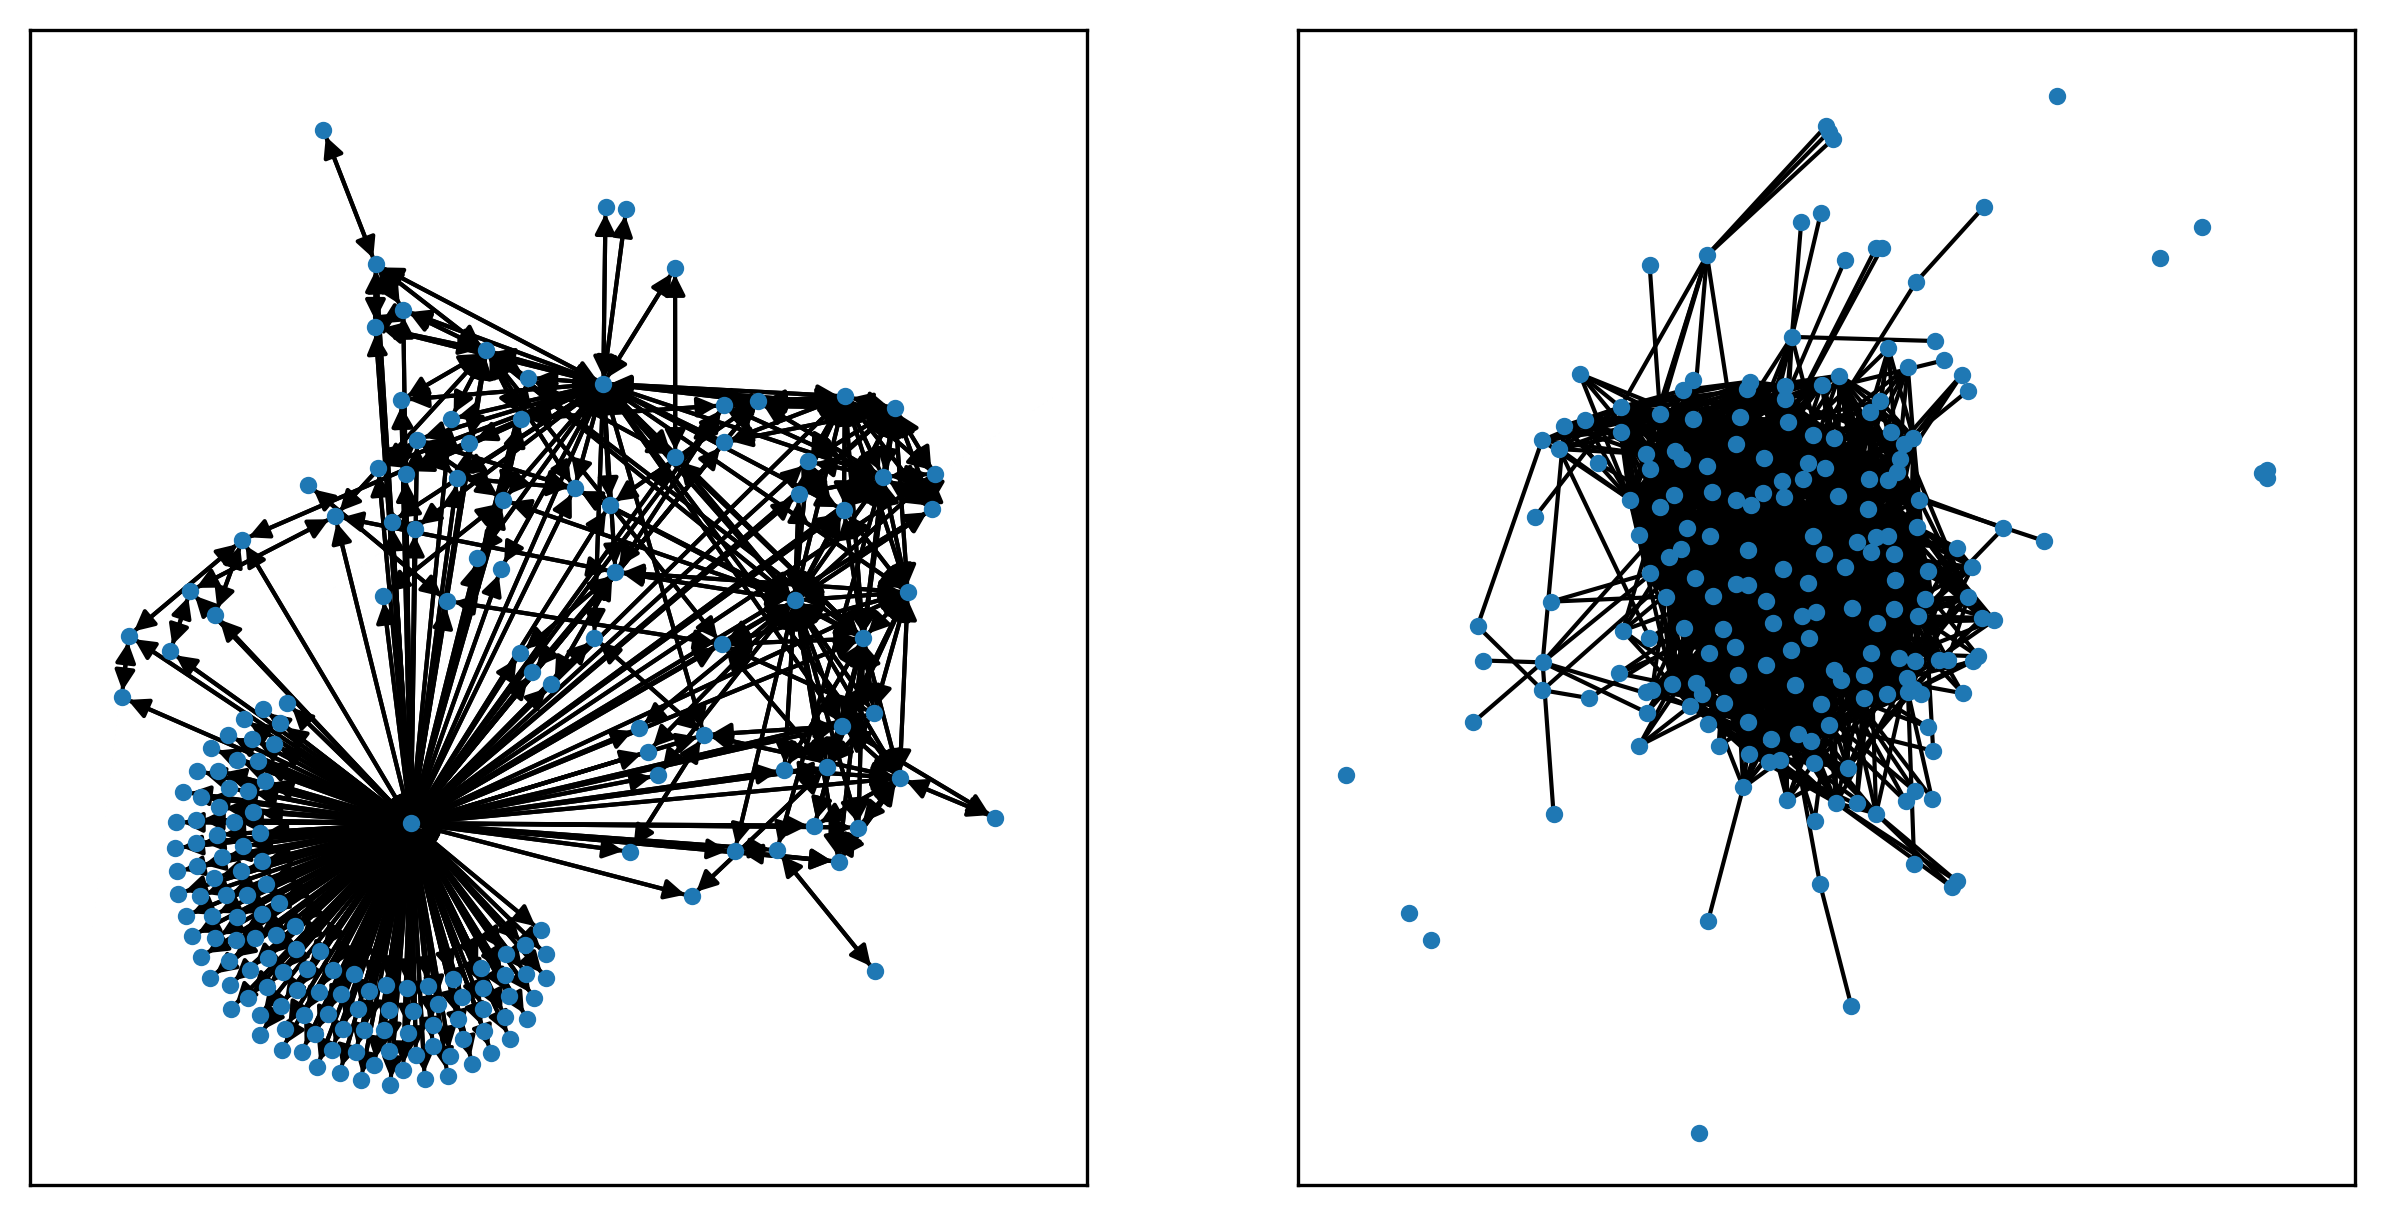

In [4]:
import matplotlib.pyplot as plt
import networkx as nx 

fig, ax = plt.subplots(1, 2, dpi=300, figsize=(10,5))

nx.draw_networkx(
    coarsener.G_coarse_,
    nx.forceatlas2_layout(coarsener.G_coarse_),
    with_labels=False,
    node_size=10,
    ax=ax[0]
)

nx.draw_networkx(
    annealer.best_graph_[0],
    nx.forceatlas2_layout(annealer.best_graph_[0]),
    with_labels=False,
    node_size=10,
    ax=ax[1]
)


(np.float64(-2578.316748046875),
 np.float64(2272.352392578125),
 np.float64(-1788.089990234375),
 np.float64(1458.734033203125))

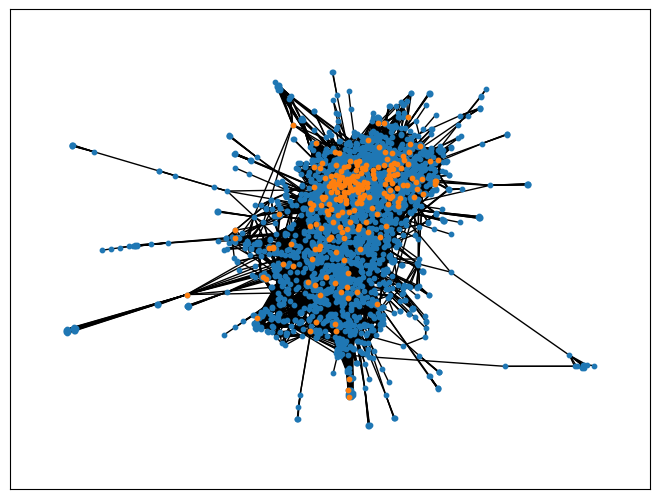

In [9]:
from minigraphs.inspection import draw_subgraph
pos = nx.forceatlas2_layout(graph_hamsterster, max_iter=300)

ax = draw_subgraph(graph_hamsterster, annealer.best_graph_[0], pos, graph_kwargs={'node_size':10}, subgraph_kwargs={'node_size': 10})

ax.axis('equal')

In [28]:
p = 1 / (200-1)
er_graph = nx.erdos_renyi_graph(200,p)
graph_spectrum(er_graph)[0]

np.float32(2.6401138)

In [30]:
nx.average_clustering(annealer.best_graph_[0])

0.4615146015725982

In [31]:
nx.average_clustering(graph_hamsterster)

0.5399779368195855

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Text(0, 0.5, 'Fraction of total population')

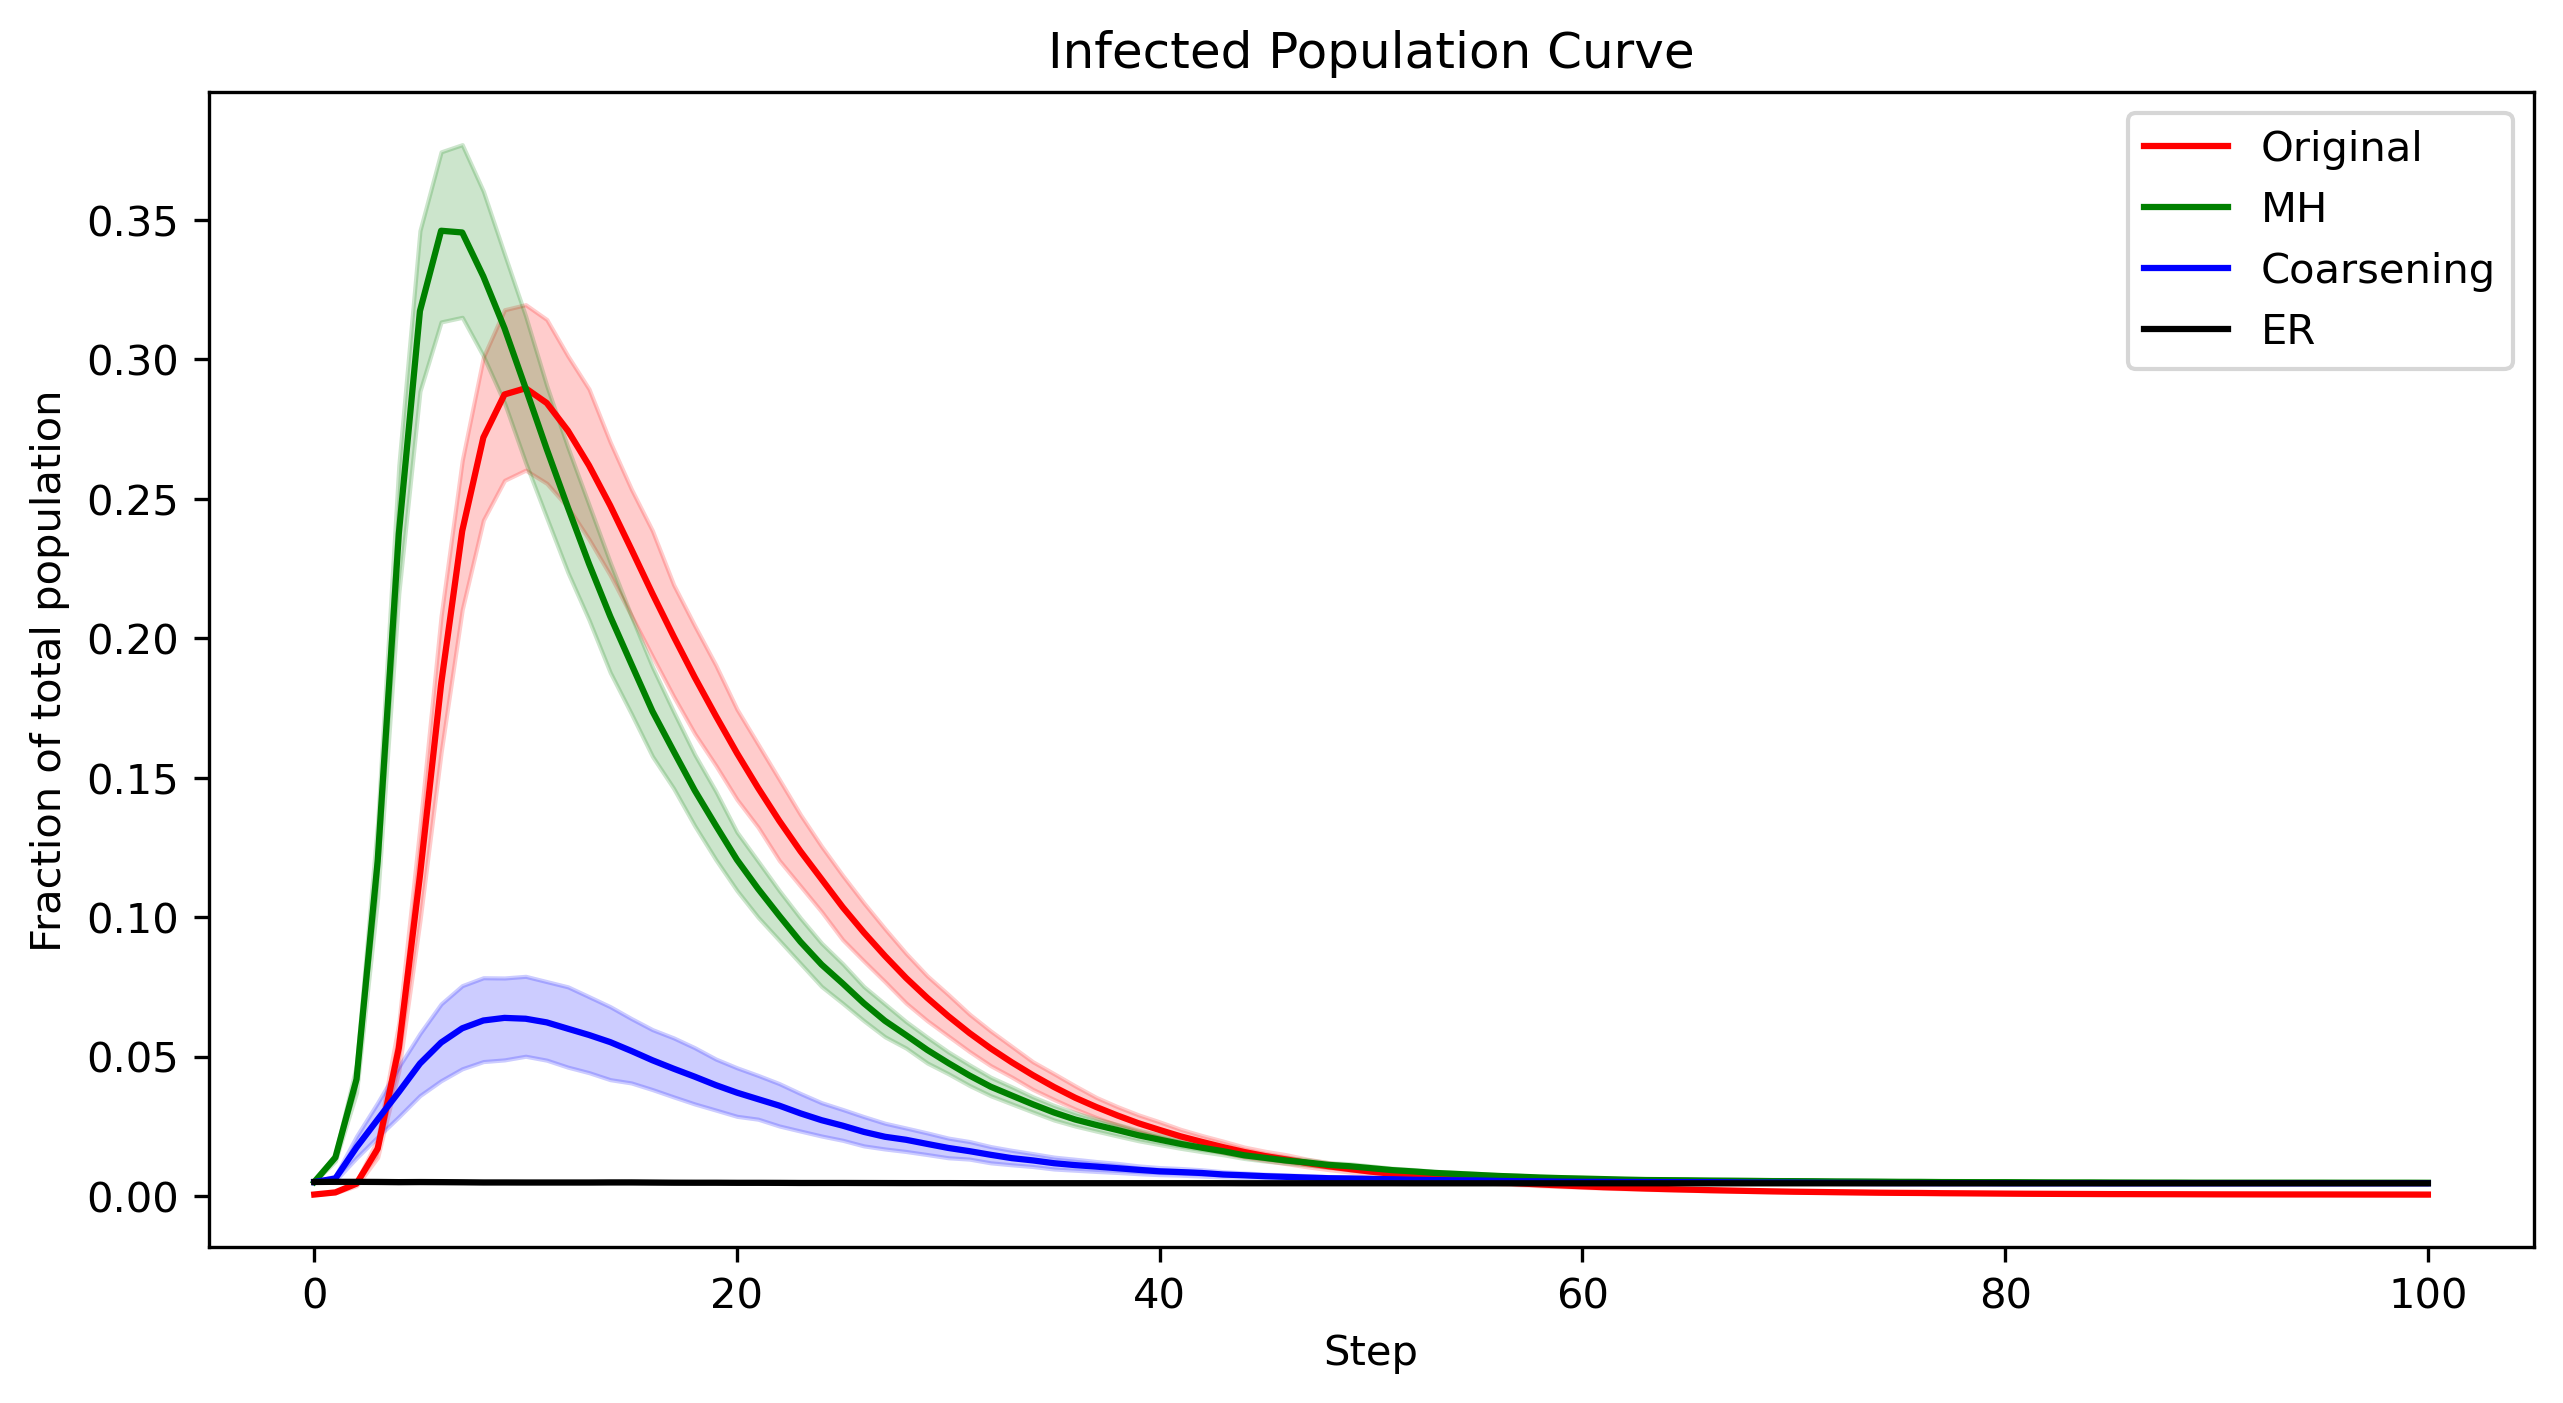

In [29]:
from minigraphs.simulation import SIRModel
from mesa.batchrunner import batch_run
from functools import partial

fig, ax = plt.subplots(dpi=300,figsize=(10,5))
color = ['r','g','b','k']
label = ['Original','MH','Coarsening','ER']

for i, graph in enumerate([graph_hamsterster, annealer.best_graph_[0], coarsener.G_coarse_, er_graph]):
    n_steps = 300
    beta = 0.1
    gamma = 0.1 

    network = nx.convert_node_labels_to_integers(graph)
    NetworkdedSIR = partial(SIRModel, network=network)

    results = batch_run(
        NetworkdedSIR,
        parameters = {
            'beta': beta, 
            'gamma': gamma,
            'n_infected': 1,
        },
        iterations=n_steps,
        max_steps=100,
        number_processes=None,
        data_collection_period=1,
        display_progress=True,
    )

    df = pd.DataFrame(results).reset_index()
    df['I'] = df['I'] / network.number_of_nodes()

    sns.lineplot(
        df,
        x='Step',
        y='I',
        ax=ax,
        color=color[i],
        label=label[i]
    )

ax.set_title("Infected Population Curve")
ax.set_ylabel("Fraction of total population")
